## Introducción a PyTorch (Parte 3)

<a target="_blank" href="https://colab.research.google.com/github/pglez82/DeepLearningWeb/blob/master/labs/notebooks/Introducci%C3%B3n%20a%20PyTorch.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

En esta tercera parte vamos a crear una pequeña red neuronal con PyTorch para resolver nuestro primer problema de clasificación. Como veremos, trabajaremos con tensores pero también con modulos ya programados en PyTorch que representan capas de una red neuronal. La clase básica para hacer esto es torch.nn.Module. Vamos a ir haciendolo paso por paso.



#### Generación y preparación del dataset
Lo primero vamos a generar unos datos. Queremos generar un dataset con cierta complejidad, que no sea **linearmente separable**. Como hemos visto en teoría un buen ejemplo de esto es el problema **XOR**.

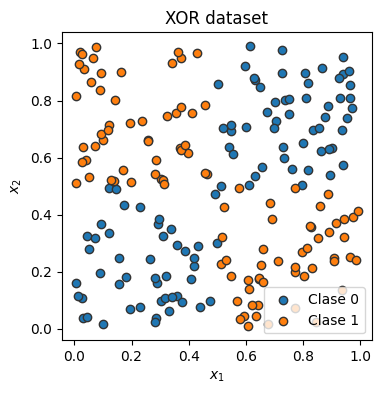

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import torch

np.random.seed(42)
torch.manual_seed(2032)

# Función para generar un dataset estilo XOR
def generate_xor_dataset(n_samples):
    
    X = np.random.rand(n_samples, 2)
    y = np.logical_xor(X[:, 0] > 0.5, X[:, 1] > 0.5)
    y = np.where(y, 1, 0)
    return X, y

# Generar dataset
X, y = generate_xor_dataset(n_samples=200)

# Plot the dataset
data_0 = X[y == 0]
data_1 = X[y == 1]

plt.figure(figsize=(4, 4))
plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Clase 0")
plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Clase 1")
plt.title("XOR dataset")
plt.ylabel(r"$x_2$")
plt.xlabel(r"$x_1$")
plt.legend()
plt.show()


Ten en cuenta que en este caso he decidido generar los datos y visualizarlos usando Numpy, pero como ya sabemos podemos convertirlos de manera muy sencilla a tensores.

In [125]:
X = torch.from_numpy(np.float32(X))
y = torch.from_numpy(y)
print("Dimension X", X.shape)
print("Dimension y", y.shape)


Dimension X torch.Size([200, 2])
Dimension y torch.Size([200])


PyTorch necesita que los datos estén en una clase que herede de **torch.data.Dataset**. Aquí tenemos muchas variantes que iremos viendo a lo largo del curso. Si tenemos ya los datos en formato numérico en un par de tensores (como es el caso), podemos usar TensorDataset. Para imágenes existen clases ya programadas. Incluso para datasets muy utilizados como ImageNet, podemos utilizar la clase **torchvision.datasets.ImageNet**. Todas ellas heredan de la misma clase e implementan los mismos métodos. 

In [126]:
from torch.utils.data import TensorDataset

dataset = TensorDataset(X,y)
print("Número de ejemplos: ",len(dataset)) #Tenemos 200 ejemplos

Número de ejemplos:  200


Puedes imaginar un Dataset en PyTorch simplemente como una clase que es capaz de devolver un único ejemplo, tenga la forma que tenga:

In [127]:
dataset[0]

(tensor([0.3745, 0.9507]), tensor(1))

Aquí hemos obtenido el primer ejemplo, que en este caso pertenece a la clase positiva.

Cuando entrenamos redes neuronales, generalmente los datos se pasan en lotes. Para ello, debemos de ser capaces de cargar múltiples ejemplos de una vez en un mini-batch. La clase que se encarga de hacer esto de manera eficiente en Pyorch es el **Dataloader**, que siempre recibe como parámetro un dataset del que cargar los datos.

In [128]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, batch_size=8, shuffle=True) #suffle true indica que los ejemplos vienen en orden aleatorio

Podemos ver por ejemplo como el DataLoader devolvería ejemplos de 8 en 8.

In [129]:
data_inputs, data_labels = next(iter(data_loader))
print("Mini-batch X", data_inputs.shape, "\n", data_inputs)
print("Mini-batch y", data_labels.shape, "\n", data_labels)

Mini-batch X torch.Size([8, 2]) 
 tensor([[0.6229, 0.0853],
        [0.1182, 0.6967],
        [0.1560, 0.1560],
        [0.9367, 0.1375],
        [0.9656, 0.8084],
        [0.5467, 0.1849],
        [0.6334, 0.8715],
        [0.7122, 0.2372]])
Mini-batch y torch.Size([8]) 
 tensor([1, 1, 0, 1, 0, 1, 0, 1])


#### Definiendo la arquitectura de la red
Una vez que tenemos los datos preparados, vamos a definir la arquitectura de la red. En este caso vamos a optar por una red totalmente conectada, simple, con una capa oculta y una función de activación ReLU en la capa oculta y sigmoide en la de salida

In [130]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Inicializar los módulos para la red
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn_hidden = nn.ReLU()
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        self.act_fn_out = nn.Sigmoid()

    def forward(self, x):
        # Definir como se hace una pasada hacia delante
        x = self.linear1(x)
        x = self.act_fn_hidden(x)
        x = self.linear2(x)
        x = self.act_fn_out(x)
        return x
    
model = MLP(num_inputs=2, num_hidden=10, num_outputs=1)
# Imprimir el modelo
print(model)


MLP(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (act_fn_hidden): ReLU()
  (linear2): Linear(in_features=10, out_features=1, bias=True)
  (act_fn_out): Sigmoid()
)


Podemos ver la estructura del modelo imprimiéndolo. También sería posible iterar sobre los parámetros aprendibles de la red:

In [131]:
for name, param in model.named_parameters():
    print(f"Parámetro {name}, forma {param.shape}")

Parámetro linear1.weight, forma torch.Size([10, 2])
Parámetro linear1.bias, forma torch.Size([10])
Parámetro linear2.weight, forma torch.Size([1, 10])
Parámetro linear2.bias, forma torch.Size([1])


#### Función de pérdida
Como ya sabemos, elegir la función de pérdida es crítico. En este caso es un problema de clasificación binario así que utilizaremos la función BCE (Binary Cross Entropy Loss). Esta función ya viene programa por defecto en PyTorch.

In [132]:
loss = nn.BCELoss()

#### Optimizador
Como ya sabemos, también debemos elegir un optimizador. Utilizaremos el más básico que es Stochastic-Gradient Descent. Tendremos que escoger también el **learning rate**.

In [133]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

#### Entrenando la red
Vamos ahora a codificar el bucle general de entrenamiento de una red. Aquí lo que haremos será iterar sobre el dataloader, ir cargando mini-batches y haciendo una pasada adelante seguida de una pasada hacia atrás para calcular los gradientes. Por último, con la ayuda del optimizador, actualizaremos los pesos de la red para seguir iterando de esta manera un número de épocas determinado.

In [134]:
from tqdm.notebook import tqdm 

def train_model(model, optimizer, data_loader, loss_module, num_epochs=1000):
    # Set model to train mode
    model.train()

    # Training loop
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        epoch_loss = 0
        for data_inputs, data_labels in data_loader:
            #Hacer una pasada hacia delante
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]
            #Calcular el valor de la función de pérdida para este mini-batch
            loss = loss_module(preds, data_labels.float())
            #Acumular el error (solo para luego mostrarlo)
            epoch_loss += loss.item()
            #Reiniciar los gradientes
            optimizer.zero_grad()
            #Pasada hacia atrás
            loss.backward()
            #Actualizar los parámetros
            optimizer.step()
        #Imprimir el error cada 50 épocas
        if epoch%50==0:
            pbar.set_description("Loss %0.2f" % epoch_loss)

train_model(model, optimizer, data_loader, loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

#### Visualización del modelo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


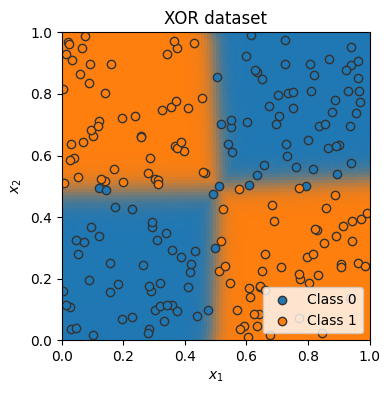

In [135]:
def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("XOR dataset")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    c0 = to_rgba("C0")
    c1 = to_rgba("C1")
    x = np.arange(0, 1, step=0.01)
    xx1, xx2 = np.meshgrid(x, x)
    model_inputs = np.stack([xx1.flatten(), xx2.flatten()], axis=-1)
    preds = model(torch.from_numpy(np.float32(model_inputs))).reshape(xx1.shape).cpu().detach().numpy()
    output_image = (1 - preds)[:, :, np.newaxis] * c0 + preds[:, :, np.newaxis] * c1

    plt.imshow(output_image, origin="lower", extent=(0, 1, 0, 1))
    plt.grid(False)

visualize_classification(model, X.cpu().numpy(), y.cpu().numpy())

### Ejercicios propuestos

1. Prueba a cambiar el número de épocas del entrenamiento. ¿Qué sucede?
2. Prueba a quitar la función de activación.
3. Prueba a cambiar el número de neuronas en la capa oculta.
4. Modifica el código para que se pueda entrenar este modelo en la GPU. Para ello deberás de mover el modelo a la gpu (cuda:0) así como los tensores necesarios
5. Calcula el acierto del modelo e imprímelo.
6. Genera un conjunto de test con las mismas características y evalúalo con este mismo modelo. ¿Qué error obtienes?